In [3]:

#require(devtools)
#devtools::install_github("rstudio/rsconnect")
#install.packages("twitteR")
#install_version("tm", version = "0.7-1", repos = "http://cran.us.r-project.org")
#install.packages("wordcloud")
#install.packages("wordcloud2")
#install.packages("syuzhet")
#install.packages("lubridate")
#install.packages("ggplot2")
#install.packages("reshape2")
#install.packages("dplyr")
#install.packages("maps")


In [34]:
library(dplyr)
library(shiny)
library(leaflet)
library(RColorBrewer)
library(rsconnect)
library(stringr)


library(twitteR)
library(tm)
library(wordcloud)
library(wordcloud2)
library(htmlwidgets)

library(maps)
library(syuzhet)
library(lubridate)
library(ggplot2)
library(scales)
library(reshape2)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘rsconnect’

The following object is masked from ‘package:shiny’:

    serverInfo


Attaching package: ‘twitteR’

The following objects are masked from ‘package:dplyr’:

    id, location

Loading required package: NLP

Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date


Attaching package: ‘ggplot2’

The following object is masked from ‘package:NLP’:

    annotate


Attaching package: ‘scales’

The following object is masked from ‘package:syuzhet’:

    rescale



In [97]:
consumer_key <- "QhK7GVJTA8TTMZLthHBOrM9Lc"
consumer_secret <- "ygKhLdqze8vLjM7tt4r28yH3jugMyb20dM0nffnKYXOkV5OlSj"
access_token <- "813554824126103552-ZVI6UyIqdn4FPMCJuSxxJSsqto3Kklo"
access_token_secret <- "mzLl9xFLPcUjVPgMGOD7HORCf71k6xJN8CbpSRJ79zJQS"

setup_twitter_oauth(consumer_key, consumer_secret, access_token, access_token_secret)

[1] "Using direct authentication"


In [98]:
hashtags <- 'terrorisme + attentats'
terroriste_tweets <- twitteR::searchTwitter(hashtags, n = 2000, retryOnRateLimit = 1e3)

In [99]:
head(terroriste_tweets, n = 2)

[[1]]
[1] "Chacha78180: RT @Damocles_Fr: Bonjour @EmmanuelMacron. Allez-vous garder dans votre équipe l'islamiste @BelattarYassine qui compare le terrorisme islami…"

[[2]]
[1] "pacota69: RT @jerome_riviere: Les familles des 239 victimes des attentats menés depuis 2015 n’ont pas le sentiment d’un anniversaire qui a mal tourné…"


In [100]:
terroriste_tweets_df<- twitteR::twListToDF(terroriste_tweets)
write.csv(terroriste_tweets_df, "./tweets_terroristes.csv", row.names=F)
summary(terroriste_tweets_df)

     text           favorited       favoriteCount      replyToSN        
 Length:2000        Mode :logical   Min.   :  0.000   Length:2000       
 Class :character   FALSE:2000      1st Qu.:  0.000   Class :character  
 Mode  :character                   Median :  0.000   Mode  :character  
                                    Mean   :  1.252                     
                                    3rd Qu.:  0.000                     
                                    Max.   :707.000                     
    created                    truncated        replyToSID       
 Min.   :2018-05-15 08:36:38   Mode :logical   Length:2000       
 1st Qu.:2018-05-16 00:11:49   FALSE:1885      Class :character  
 Median :2018-05-17 21:14:14   TRUE :115       Mode  :character  
 Mean   :2018-05-17 21:29:52                                     
 3rd Qu.:2018-05-18 17:06:21                                     
 Max.   :2018-05-21 11:42:58                                     
      id             replyT

In [101]:
df_terroriste = read.csv("./tweets_terroristes.csv", header=T)
dim(df_terroriste)

[1] 2000   16

In [102]:
corpus <- iconv(df_terroriste$text, to ="utf-8")
corpus <- Corpus(VectorSource(corpus))
corpus <- tm_map(corpus, tolower)
corpus <- tm_map(corpus, removePunctuation)
corpus <- tm_map(corpus, removeNumbers)

inspect(corpus[1:5])

<<SimpleCorpus>>
Metadata:  corpus specific: 1, document level (indexed): 0
Content:  documents: 5

[1] rt damoclesfr bonjour emmanuelmacron allezvous garder dans votre équipe lislamiste belattaryassine qui compare le terrorisme islami
[2] rt jeromeriviere les familles des  victimes des attentats menés depuis  nont pas le sentiment dun anniversaire qui a mal tourné    
[3] rt pascalpointud une fois de plus mr belattar bat les records httpstcoftpkqdszsq faire un parallèle avec une fête danniversaire et 
[4] rt pascalpointud une fois de plus mr belattar bat les records httpstcoftpkqdszsq faire un parallèle avec une fête danniversaire et 
[5] rt damoclesfr bonjour emmanuelmacron allezvous garder dans votre équipe lislamiste belattaryassine qui compare le terrorisme islami


In [103]:
cleanset <- tm_map(corpus, removeWords, stopwords('french'))
removeURL <- function(x) gsub('http[[:alnum:]]*', '',x)
cleanset <- tm_map(cleanset, content_transformer(removeURL))
inspect(cleanset[1:5])

<<SimpleCorpus>>
Metadata:  corpus specific: 1, document level (indexed): 0
Content:  documents: 5

[1] rt damoclesfr bonjour emmanuelmacron allezvous garder   équipe lislamiste belattaryassine  compare  terrorisme islami
[2] rt jeromeriviere  familles   victimes  attentats menés depuis  nont   sentiment dun anniversaire  a mal tourné       
[3] rt pascalpointud  fois  plus mr belattar bat  records  faire  parallèle   fête danniversaire                         
[4] rt pascalpointud  fois  plus mr belattar bat  records  faire  parallèle   fête danniversaire                         
[5] rt damoclesfr bonjour emmanuelmacron allezvous garder   équipe lislamiste belattaryassine  compare  terrorisme islami


In [104]:

cleanset <- tm_map(cleanset, removeWords, c('cest', 'res','paris','france','Ici','encore',
                                            'gvt','pre','aucune','mlpofficiel','aucune','encore',
                                            'pre','gvt','quils','sncf', 'nicolassarkozy',
                                            'lponiatowski','disent','letat', 'listes'))

cleanset <- tm_map(cleanset, stripWhitespace)
inspect(cleanset[1:5])

<<SimpleCorpus>>
Metadata:  corpus specific: 1, document level (indexed): 0
Content:  documents: 5

[1] rt damoclesfr bonjour emmanuelmacron allezvous garder équipe lislamiste belattaryassine compare terrorisme islami
[2] rt jeromeriviere familles victimes attentats menés depuis nont sentiment dun anniversaire a mal tourné           
[3] rt pascalpointud fois plus mr belattar bat records faire parallèle fête danniversaire                            
[4] rt pascalpointud fois plus mr belattar bat records faire parallèle fête danniversaire                            
[5] rt damoclesfr bonjour emmanuelmacron allezvous garder équipe lislamiste belattaryassine compare terrorisme islami


In [105]:
tdm <- TermDocumentMatrix(cleanset)
tdm

<<TermDocumentMatrix (terms: 985, documents: 2000)>>
Non-/sparse entries: 19538/1950462
Sparsity           : 99%
Maximal term length: 18
Weighting          : term frequency (tf)

In [106]:
tdm <- as.matrix(tdm)
tdm[5:15, 20:35]

,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35
damoclesfr,1,0,1,0,1,0,0,0,0,0,1,0,0,0,1,1
emmanuelmacron,1,0,1,0,1,0,0,0,0,0,1,0,0,0,1,1
garder,1,0,1,0,1,0,0,0,0,0,1,0,0,0,1,1
islami,1,0,1,0,1,0,0,0,0,0,1,0,0,0,1,1
lislamiste,1,0,1,0,1,0,0,0,0,0,1,0,0,0,1,1
terrorisme,1,1,1,0,1,0,0,0,0,0,1,0,0,0,1,1
équipe,1,0,1,0,1,0,0,0,0,0,1,0,0,0,1,1
anniversaire,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0
attentats,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0
depuis,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0


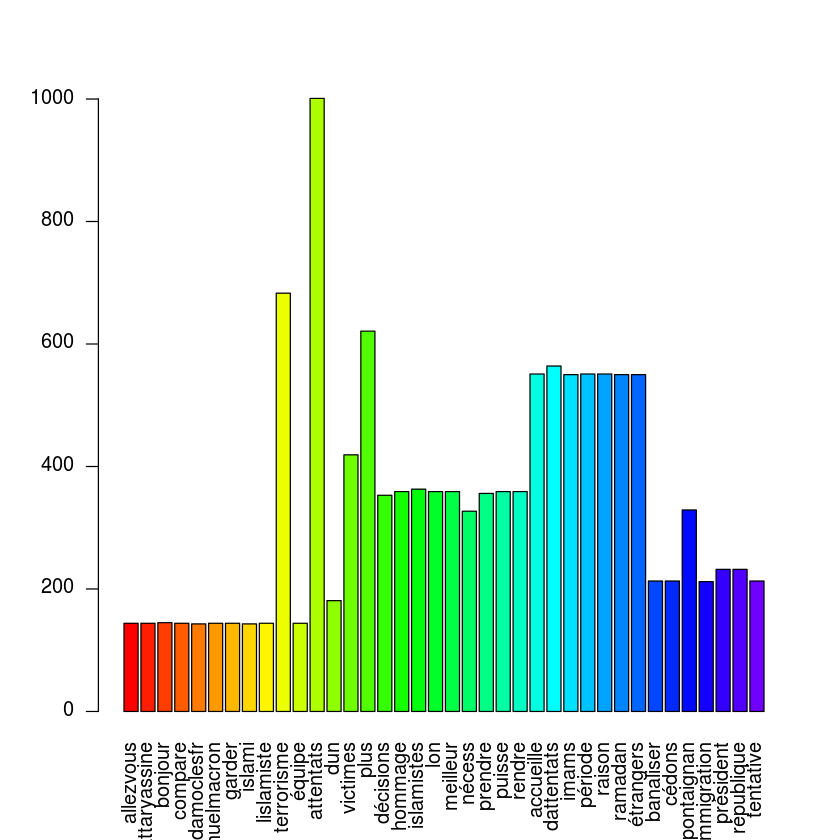

In [107]:
#plot
w <- rowSums(tdm)
w <- subset(w,w >=100)
barplot(w, las = 2, col = rainbow(50))

Warning message in brewer.pal(10, "Dark2"):
“n too large, allowed maximum for palette Dark2 is 8
Returning the palette you asked for with that many colors
”

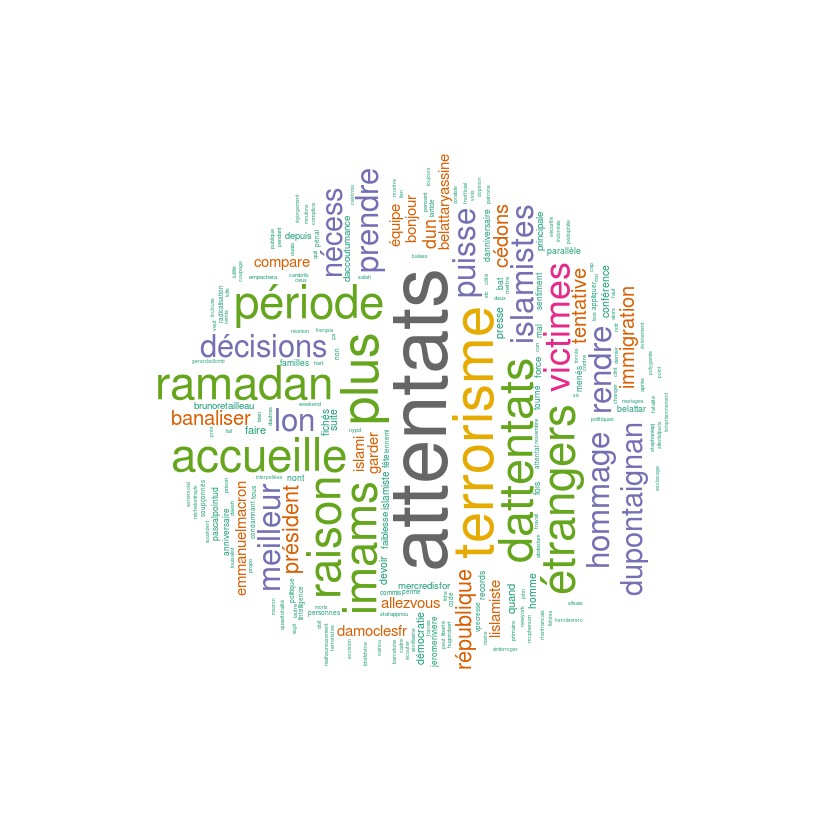

In [108]:
w <- sort(rowSums(tdm), decreasing = TRUE)
set.seed(222)
wordcloud(words = names(w), freq=w, max.words = 200, random.order = F, min.freq= 3, 
          colors = brewer.pal(10, 'Dark2'), scale = c(4,0.2), rot.per = 0.8) 

In [112]:

w <- data.frame(names(w), w)
colnames(w) <- c('word','freq')

ERROR: Error in data.frame(names(w), w): arguments imply differing number of rows: 2, 985


In [113]:
tweets <- iconv(df_terroriste$text, to ="utf-8")
s <- get_nrc_sentiment(tweets)
head(s)

anger,anticipation,disgust,fear,joy,sadness,surprise,trust,negative,positive
0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0


In [114]:
get_nrc_sentiment('delay')

anger,anticipation,disgust,fear,joy,sadness,surprise,trust,negative,positive
1,0,1,1,0,1,0,0,1,0


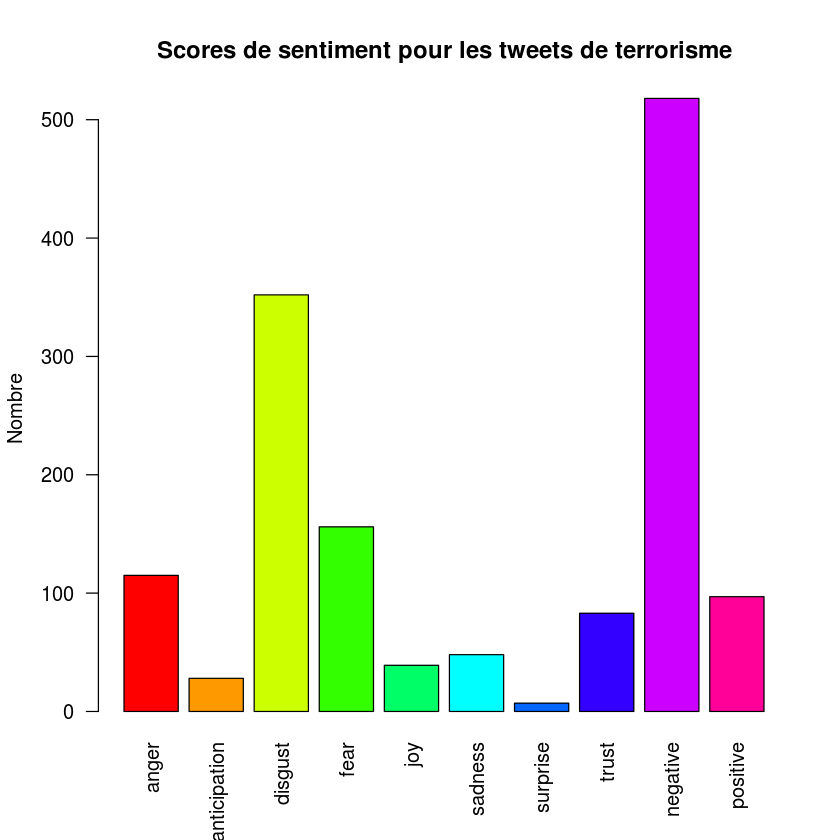

In [115]:
barplot(colSums(s), las= 2, col=rainbow(10), ylab='Nombre', main ="Scores de sentiment pour les tweets de terrorisme")

In [35]:
#ouverture du dataset de START
dataframe_terrorism <- read.csv("globalterrorismdb_0617dist.csv", header= TRUE, stringsAsFactors=FALSE, sep = ",")

In [36]:
names(dataframe_terrorism)

[1] "eventid"            "iyear"              "imonth"            
  [4] "iday"               "approxdate"         "extended"          
  [7] "resolution"         "country"            "country_txt"       
 [10] "region"             "region_txt"         "provstate"         
 [13] "city"               "latitude"           "longitude"         
 [16] "specificity"        "vicinity"           "location"          
 [19] "summary"            "crit1"              "crit2"             
 [22] "crit3"              "doubtterr"          "alternative"       
 [25] "alternative_txt"    "multiple"           "success"           
 [28] "suicide"            "attacktype1"        "attacktype1_txt"   
 [31] "attacktype2"        "attacktype2_txt"    "attacktype3"       
 [34] "attacktype3_txt"    "targtype1"          "targtype1_txt"     
 [37] "targsubtype1"       "targsubtype1_txt"   "corp1"             
 [40] "target1"            "natlty1"            "natlty1_txt"       
 [43] "targtype2"          "targtype2_txt"      "targsubtype2"      
 [46] "targsubtype2_txt"   "corp2"              "target2"           
 [49] "natlty2"            "natlty2_txt"        "targtype3"         
 [52] "targtype3_txt"      "targsubtype3"       "targsubtype3_txt"  
 [55] "corp3"              "target3"            "natlty3"           
 [58] "natlty3_txt"        "gname"              "gsubname"          
 [61] "gname2"             "gsubname2"          "gname3"            
 [64] "gsubname3"          "motive"             "guncertain1"       
 [67] "guncertain2"        "guncertain3"        "individual"        
 [70] "nperps"             "nperpcap"           "claimed"           
 [73] "claimmode"          "claimmode_txt"      "claim2"            
 [76] "claimmode2"         "claimmode2_txt"     "claim3"            
 [79] "claimmode3"         "claimmode3_txt"     "compclaim"         
 [82] "weaptype1"          "weaptype1_txt"      "weapsubtype1"      
 [85] "weapsubtype1_txt"   "weaptype2"          "weaptype2_txt"     
 [88] "weapsubtype2"       "weapsubtype2_txt"   "weaptype3"         
 [91] "weaptype3_txt"      "weapsubtype3"       "weapsubtype3_txt"  
 [94] "weaptype4"          "weaptype4_txt"      "weapsubtype4"      
 [97] "weapsubtype4_txt"   "weapdetail"         "nkill"             
[100] "nkillus"            "nkillter"           "nwound"            
[103] "nwoundus"           "nwoundte"           "property"          
[106] "propextent"         "propextent_txt"     "propvalue"         
[109] "propcomment"        "ishostkid"          "nhostkid"          
[112] "nhostkidus"         "nhours"             "ndays"             
[115] "divert"             "kidhijcountry"      "ransom"            
[118] "ransomamt"          "ransomamtus"        "ransompaid"        
[121] "ransompaidus"       "ransomnote"         "hostkidoutcome"    
[124] "hostkidoutcome_txt" "nreleased"          "addnotes"          
[127] "scite1"             "scite2"             "scite3"            
[130] "dbsource"           "INT_LOG"            "INT_IDEO"          
[133] "INT_MISC"           "INT_ANY"            "related"

In [37]:
keep <- c("iyear",
          "imonth",
          "iday",
          "resolution",
          "country_txt",
          "region_txt",
          "provstate",
          "city",
          "latitude",
          "longitude",
          #RAJOUTER GROUPES TERRORISTES ?
          "doubtterr",
          "attacktype1_txt",
          "targtype1_txt",
          "targsubtype1_txt",
          "natlty1_txt",
          "suicide",
          "weaptype1_txt",
          "nkill",
          "nwound",
          "propextent_txt",
          "success"
)

dataframe_terrorism <- dataframe_terrorism[keep]
dim(dataframe_terrorism)

[1] 170350     21

In [38]:
names(dataframe_terrorism)

[1] "iyear"            "imonth"           "iday"             "resolution"      
 [5] "country_txt"      "region_txt"       "provstate"        "city"            
 [9] "latitude"         "longitude"        "doubtterr"        "attacktype1_txt" 
[13] "targtype1_txt"    "targsubtype1_txt" "natlty1_txt"      "suicide"         
[17] "weaptype1_txt"    "nkill"            "nwound"           "propextent_txt"  
[21] "success"

In [39]:
dataframe_terrorism <- subset(dataframe_terrorism, doubtterr == "0")
#Suppression de la variable "doute_terr"/"doubtterr", après avoir gardé seulement les évènements dont l'acte terroriste est indéniable
dataframe_terrorism <- subset(dataframe_terrorism, select = -c(doubtterr))

In [40]:

names(dataframe_terrorism)

[1] "iyear"            "imonth"           "iday"             "resolution"      
 [5] "country_txt"      "region_txt"       "provstate"        "city"            
 [9] "latitude"         "longitude"        "attacktype1_txt"  "targtype1_txt"   
[13] "targsubtype1_txt" "natlty1_txt"      "suicide"          "weaptype1_txt"   
[17] "nkill"            "nwound"           "propextent_txt"   "success"

In [41]:
#Calcul du nombre d'observations conservées. Seules celles dont un acte terroriste est indubitable ont été gardées
dim(dataframe_terrorism)

[1] 129942     20

In [42]:
#Vérification de la dataframe pour les observations manquantes
colSums(is.na(dataframe_terrorism))


iyear           imonth             iday       resolution 
               0                0                0                0 
     country_txt       region_txt        provstate             city 
               0                0                0                0 
        latitude        longitude  attacktype1_txt    targtype1_txt 
            2868             2868                0                0 
targsubtype1_txt      natlty1_txt          suicide    weaptype1_txt 
               0                0                0                0 
           nkill           nwound   propextent_txt          success 
            6354            10281                0                0

In [43]:
#Suppression des observations dont les coordonnées géographiques (longitude ou latitude) sont manquantes
table(is.na(dataframe_terrorism$latitude))
dataframe_terrorism <-dataframe_terrorism[!is.na(dataframe_terrorism$latitude),]



 FALSE   TRUE 
127074   2868 

In [44]:
#Deuxième vérification pour identifier les observations nulles
colSums(is.na(dataframe_terrorism))

iyear           imonth             iday       resolution 
               0                0                0                0 
     country_txt       region_txt        provstate             city 
               0                0                0                0 
        latitude        longitude  attacktype1_txt    targtype1_txt 
               0                0                0                0 
targsubtype1_txt      natlty1_txt          suicide    weaptype1_txt 
               0                0                0                0 
           nkill           nwound   propextent_txt          success 
            6043             9914                0                0

In [45]:
#suppression des observations manquantes pour la variable "nwound"
dataframe_terrorism <- dataframe_terrorism[!is.na(dataframe_terrorism$nwound & dataframe_terrorism$nkill),]

colSums(is.na(dataframe_terrorism))

iyear           imonth             iday       resolution 
               0                0                0                0 
     country_txt       region_txt        provstate             city 
               0                0                0                0 
        latitude        longitude  attacktype1_txt    targtype1_txt 
               0                0                0                0 
targsubtype1_txt      natlty1_txt          suicide    weaptype1_txt 
               0                0                0                0 
           nkill           nwound   propextent_txt          success 
              65              498                0                0

In [46]:
#Suppression des observations dont le mois == 0
dataframe_terrorism <- subset(dataframe_terrorism, imonth!= "0" & iday!="0")

In [47]:
temps_de_resolution <- c()

ecart_resolution  <- function(df) { 
  year <- df["iyear"]
  month <- df["imonth"]
  day <- df["iday"]
  # gsub nous permet d'enlever les espaces, ce qui va nous permetre de concaténer.
  month <- gsub(" ", "", month, fixed = TRUE)
  day <- gsub(" ", "", day, fixed = TRUE)
  #placement des variables au sein d'un vecteur (aka "liste")
  x <- cbind(year,month,day)
  
  dateDeDebut <- as.Date(str_c(x, collapse = "/"))
  #str_c nous permet de transformer notre vecteur en string en fusionnant tous les éléments de celui-ci et avec l'argument "collapse on" mais un slash entre les éléments ce qui va nous permettre de recréer la date
  #as.Date nous permet de convertir un string en date
  
  #Après avoir reconstituer la date, nous allons pouvoir calculer le temps entre le début d'une attaque et la fin, dotn la date apparaît dans la variable "resolution"
  if(df["resolution"] != "" || is.null(df["resolution"]) ){
    dateDeResolution <- as.Date(df["resolution"], "%m/%d/%Y")
    
    tempsDeResolutionEnJour <- dateDeResolution - dateDeDebut 
    #df["temps_de_resolution"] <- tempsDeResolutionEnJour
    temps_de_resolution <- c(temps_de_resolution,tempsDeResolutionEnJour)
    print(temps_de_resolution)
    
    
  }else{
    temps_de_resolution <- c(temps_de_resolution,NA)
  }
  return(temps_de_resolution)
}



In [48]:
dataframe_terrorism$temps_de_resolution_en_jour <- apply(dataframe_terrorism, 1, ecart_resolution)

[1] 2
[1] 4
[1] 1
[1] 4
[1] 5
[1] 3
[1] 49
[1] 1
[1] 3
[1] 3
[1] 5
[1] 1
[1] 7
[1] 205
[1] 10
[1] 6
[1] 6
[1] 1
[1] 1
[1] 59
[1] 8
[1] 23
[1] 43
[1] 244
[1] 23
[1] 6
[1] 7
[1] 1
[1] 21
[1] 20
[1] 1
[1] 10
[1] 1
[1] 12
[1] -660
[1] 5
[1] 66
[1] 40
[1] 2
[1] 2
[1] 65
[1] 11
[1] 3
[1] 3
[1] 3
[1] 4
[1] 1
[1] 94
[1] 2
[1] 135
[1] 1
[1] 1
[1] 2
[1] 4
[1] 107
[1] 26
[1] 19
[1] 136
[1] 5
[1] 13
[1] 13
[1] 4
[1] 3
[1] 5
[1] 2
[1] 5
[1] 294
[1] 2
[1] 31
[1] 4
[1] 35
[1] 61
[1] 29
[1] 12
[1] 164
[1] 2
[1] 3
[1] 29
[1] 62
[1] 1225
[1] 22
[1] 20
[1] 0
[1] 6
[1] 5
[1] 1
[1] 4
[1] 0
[1] 1
[1] 28
[1] 232
[1] 62
[1] 3
[1] 15
[1] 18
[1] 2
[1] 86
[1] 89
[1] 29
[1] 7324
[1] 19
[1] 2
[1] 21
[1] 5
[1] 44
[1] 111
[1] 1
[1] 9
[1] 89
[1] 10
[1] 1
[1] 36
[1] 1
[1] 1
[1] 6
[1] 30
[1] 14
[1] 62
[1] 14
[1] 1
[1] 1
[1] 161
[1] 53
[1] 24
[1] 21
[1] 219
[1] 0
[1] 0
[1] 1
[1] 7
[1] 52
[1] 214
[1] 1
[1] 63
[1] 7
[1] 10
[1] 19
[1] 6
[1] 1
[1] 32
[1] 5
[1] 85
[1] 17
[1] 106
[1] 1
[1] 18
[1] 5
[1] 8
[1] 1
[1] 1
[1] 2
[1]

In [49]:
#Changer les observations manquantes des variables qualitatives par "Unknown" 
#("Unknown" signifie "information inconnue")
dataframe_terrorism[dataframe_terrorism==""]<-"Unknown"

#changer valeurs "unknown" de la variable/colonne "resolution" en espaces vides " "
dataframe_terrorism$resolution<-gsub("Unknown","",dataframe_terrorism$resolution)



In [50]:
lieuxDesAttentas <- data.frame(Ville = dataframe_terrorism$city,
                               Latitude = dataframe_terrorism$latitude,
                               Longitude = dataframe_terrorism$longitude,
                               temps_de_resolution = dataframe_terrorism$temps_de_resolution_en_jour,
                               Suicide = dataframe_terrorism$suicide,
                               Success = dataframe_terrorism$success,
                               #nomATK = dataframe_terrorism$gname,
                               iyear = dataframe_terrorism$iyear)

In [51]:
data_attak_success <- subset(dataframe_terrorism, success == "0")
lieuxDesAttentas <- data.frame(Ville = data_attak_success$city,
                               Latitude = data_attak_success$latitude,
                               Longitude = data_attak_success$longitude,
                               temps_de_resolution = data_attak_success$temps_de_resolution_en_jour,
                               Suicide = data_attak_success$suicide,
                               #nomATK = dataframe_terrorism$gname,
                               iyear = data_attak_success $iyear)



In [63]:
r_colors <- rgb(t(col2rgb(colors()) / 255))
names(r_colors) <- colors()

ui <- fluidPage(
  leafletOutput("map"),
  p(),
  sliderInput("range", "Annees", min(lieuxDesAttentas$iyear), max(lieuxDesAttentas$iyear),
              value = range(2013,2014), step = 1
  ),
    hr(),
    selectInput('selectVille', "Villes",  choices = lieuxDesAttentas$Ville),
        hr(),
    #selectInput('selectionSuccess', "Attaque Reussi ", choices= lieuxDesAttentas$Success, selected="0"),
     #   hr(),
    selectInput('selectSuicide', "Attaque suicide", choices= lieuxDesAttentas$Suicide),
    hr()
)

In [ ]:
server <- function(input, output, session) {
  # Reactive expression for the data subsetted to what the user selected
  filteredData <- reactive({

    lieuxDesAttentas[c(lieuxDesAttentas$iyear >= input$range[1] & lieuxDesAttentas$iyear <= input$range[2],
                              lieuxDesAttentas$Suicide == input$selectSuicide,
                      lieuxDesAttentas$Ville == input$selectVille),]

  })
  
  
  #  points <- eventReactive(input$recalc, {
  #    cbind(rnorm(40) * 2 + 13, rnorm(40) + 48)
  #  }, ignoreNULL = FALSE)
  
  output$map <- renderLeaflet({
    leaflet(lieuxDesAttentas) %>% addTiles() %>%
      addCircles(lng = ~Longitude, lat = ~Latitude, weight = 2,
                 radius = 50, #popup = ~paste(Ville, ":", nomATK),
                 color = "#FF0000", fillOpacity = 0.2)
  })
  
  # Incremental changes to the map (in this case, replacing the
  # circles when a new color is chosen) should be performed in
  # an observer. Each independent set of things that can change
  # should be managed in its own observer.
  observe({
    leafletProxy("map", data = filteredData()) %>%
      clearShapes() %>%
          leaflet(lieuxDesAttentas) %>% 
      
      addCircles(lng = ~Longitude, lat = ~Latitude, weight = 2,
                 radius = 50, #popup = ~paste(Ville, ":", nomATK),
                 color = "#FF0000", fillOpacity = 0.2)
      
    
  })
}

shinyApp(ui= ui, server =server)



Listening on http://127.0.0.1:7189
Warning message:
“Error in UseMethod: pas de méthode pour 'metaData' applicable pour un objet de classe "leaflet_proxy"”